# 1. Исследовательский анализ данных

1 Загрузим необходимые библиотеки, датасет, изображения и получим общую информацию

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    batch_size=16,
    target_size=(224,224),
    seed=42)

Found 7591 validated image filenames.


Мы имеем выборку из 7591 изображений. К каждому изображению имеется название файла и значение целевого признака - возраст человека на изображении.

2 Построим график распределения возраста в выборке

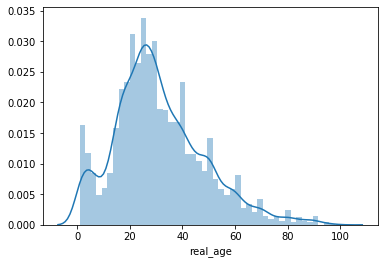

In [4]:
sns.distplot(labels['real_age'])


In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

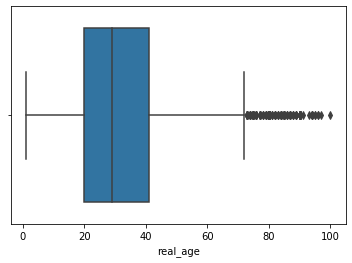

In [6]:
sns.boxplot(labels['real_age'])

Графики распределения возраста показывают, что на изображения показаны люди в возрасте от 1 до 100 лет. Большинство людей представлено в возрасте от 20 до 40 лет. Распределение смещено вправо

3 Отразим на экране фото батча

(16, 224, 224, 3)


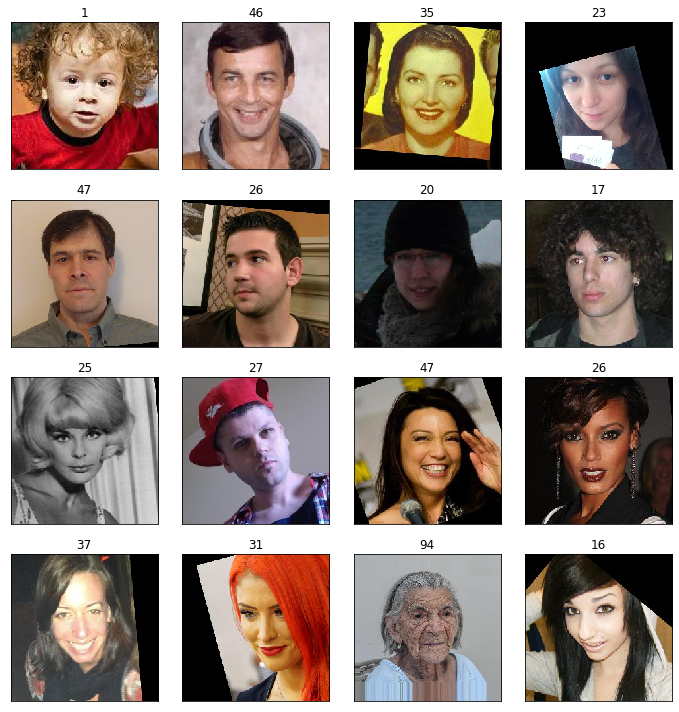

In [7]:
features, target = next(train_datagen_flow)
print(features.shape)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете представлены абсолютно разные изображения людей: разного качества, снятые в разные периоды, разные эмоции, разного типа (селфи, фото), разный фон, черно-белые и цветные.

Вывод: Датасет хорошо сформирован для обучения: имеется большая выборка -7591 изображение, распределение по возрасту соответствует фактическому мировому распределению возрастных групп, в датасете представлены различные изображения. Для обучения подойдет архитектура  ResNet50,предобученной на датасете ImageNet, т.к. она хорошо себя показывает на задачах регрессии в компьютерном зрении

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    vertical_flip=True,
    horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    batch_size=32,
    target_size=(224,224),
    seed=42,
    subset='training')
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    batch_size=32,
    target_size=(224,224),
    seed=42,
    subset='validation')
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```python
Train for 178 steps, validate for 60 steps
Epoch 1/5
2020-09-08 03:35:37.167856: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-09-08 03:35:37.955467: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 103s - loss: 256.6007 - mae: 11.6640 - val_loss: 808.3096 - val_mae: 23.4151
Epoch 2/5
178/178 - 41s - loss: 102.8616 - mae: 7.6233 - val_loss: 384.3034 - val_mae: 14.5939
Epoch 3/5
178/178 - 41s - loss: 79.2951 - mae: 6.7102 - val_loss: 268.8721 - val_mae: 12.4143
Epoch 4/5
178/178 - 42s - loss: 64.1292 - mae: 6.0638 - val_loss: 139.4752 - val_mae: 9.0116
Epoch 5/5
178/178 - 42s - loss: 55.2814 - mae: 5.5858 - val_loss: 104.5546 - val_mae: 7.7385
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 104.5546 - mae: 7.7385
Test MAE: 7.7385
```

# 3. Анализ обученной модели

Обученная модель выполнена на базе архитектуры ResNet50,предобученной на датасете ImageNet. Метрика МАЕ на тренировочной выборке составила 5.59, на тестовой - 7.74. Я считаю, что модель переобучилась. Можно попробовать уменьшить метрику: увеличить скорость lr, увеличить количество эпох, увеличить target_size до исходного 256х256. P.S. Я этот вывод уже писал, но почему-то он не сохранился)